In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import time
 

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [118]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.438, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [119]:
dataset_path = './Food_classifier'
dataset = datasets.ImageFolder(dataset_path, transform=transform) 

In [120]:
dataset.classes[1]

'Crispy Chicken'

In [121]:
class_names = dataset.classes
class_names

['Baked Potato',
 'Crispy Chicken',
 'Donut',
 'Fries',
 'Hot Dog',
 'Sandwich',
 'Taco',
 'Taquito',
 'apple_pie',
 'burger',
 'butter_naan',
 'chai',
 'chapati',
 'cheesecake',
 'chicken_curry',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'ice_cream',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'omelette',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa',
 'sushi']

In [122]:
num_classes = len(class_names)
num_classes

34

In [123]:
train_size = int(0.75*len(dataset))
test_size = len(dataset)-train_size

print(train_size)
print(test_size)

3581
1194


In [124]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [143]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [126]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [127]:
[dataset.classes[i] for i in labels[:16]]

['chicken_curry',
 'kadai_paneer',
 'cheesecake',
 'sushi',
 'Sandwich',
 'Taco',
 'cheesecake',
 'omelette',
 'Taco',
 'Fries',
 'sushi',
 'cheesecake',
 'samosa',
 'Donut',
 'apple_pie',
 'Taquito']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571..1.82].


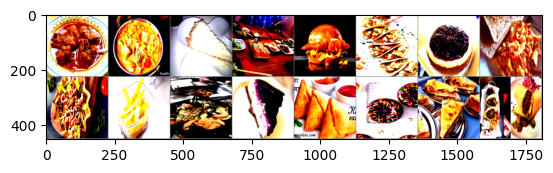

In [128]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show
imshow(torchvision.utils.make_grid(images[:16]))

In [ ]:
class FoodClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2 , padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.network(x)

In [152]:
def train_model(model, criterion, optimizer, epochs = 5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num,(images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epochs: { epoch+1}, loss: {loss.item():.2f}")

            running_loss += loss.item()* images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        print(f"Epochs: {epoch+1}/{epochs}, Epoch_loss: {epoch_loss:.4f}")

        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in test_loader:
                 images, labels = images.to(device), labels.to(device)
                 outputs = model(images)
                 _, predicted = torch.max(outputs.data,1)
                 total += labels.size(0)
                 correct += (predicted == labels).sum().item()
                 all_labels.extend(labels.cpu().numpy())
                 all_predictions.extend(predicted.cpu().numpy())

        print(f"*** validation accuracy: { 100 * correct / total:.2f}")

    end = time.time()
    print(f" Exection time: { end - start} seconds")

    return all_labels, all_predictions

In [153]:
model = FoodClassifier(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epochs: 1, loss: 3.36
Batch: 20, Epochs: 1, loss: 3.39
Batch: 30, Epochs: 1, loss: 3.04
Batch: 40, Epochs: 1, loss: 3.14
Batch: 50, Epochs: 1, loss: 3.08
Batch: 60, Epochs: 1, loss: 3.12
Batch: 70, Epochs: 1, loss: 2.96
Batch: 80, Epochs: 1, loss: 3.07
Batch: 90, Epochs: 1, loss: 3.36
Batch: 100, Epochs: 1, loss: 2.88
Batch: 110, Epochs: 1, loss: 3.19
Epochs: 1/5, Epoch_loss: 3.2045
*** validation accuracy: 14.32
Batch: 10, Epochs: 2, loss: 2.85
Batch: 20, Epochs: 2, loss: 2.77
Batch: 30, Epochs: 2, loss: 3.24
Batch: 40, Epochs: 2, loss: 2.98
Batch: 50, Epochs: 2, loss: 2.78
Batch: 60, Epochs: 2, loss: 2.80
Batch: 70, Epochs: 2, loss: 2.69
Batch: 80, Epochs: 2, loss: 2.82
Batch: 90, Epochs: 2, loss: 2.93
Batch: 100, Epochs: 2, loss: 2.95
Batch: 110, Epochs: 2, loss: 2.48
Epochs: 2/5, Epoch_loss: 2.7956
*** validation accuracy: 18.93
Batch: 10, Epochs: 3, loss: 2.78
Batch: 20, Epochs: 3, loss: 2.50
Batch: 30, Epochs: 3, loss: 2.41
Batch: 40, Epochs: 3, loss: 2.48
Batch: 50, E

In [154]:
class ClothesClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x 

In [155]:
model = ClothesClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10 )

Batch: 10, Epochs: 1, loss: 2.57
Batch: 20, Epochs: 1, loss: 2.94
Batch: 30, Epochs: 1, loss: 1.85
Batch: 40, Epochs: 1, loss: 1.42
Batch: 50, Epochs: 1, loss: 1.64
Batch: 60, Epochs: 1, loss: 1.40
Batch: 70, Epochs: 1, loss: 1.19
Batch: 80, Epochs: 1, loss: 1.00
Batch: 90, Epochs: 1, loss: 0.76
Batch: 100, Epochs: 1, loss: 0.96
Batch: 110, Epochs: 1, loss: 1.29
Epochs: 1/10, Epoch_loss: 1.6547
*** validation accuracy: 75.80
Batch: 10, Epochs: 2, loss: 0.68
Batch: 20, Epochs: 2, loss: 0.99
Batch: 30, Epochs: 2, loss: 0.45
Batch: 40, Epochs: 2, loss: 0.56
Batch: 50, Epochs: 2, loss: 0.63
Batch: 60, Epochs: 2, loss: 0.41
Batch: 70, Epochs: 2, loss: 0.55
Batch: 80, Epochs: 2, loss: 0.23
Batch: 90, Epochs: 2, loss: 0.35
Batch: 100, Epochs: 2, loss: 0.27
Batch: 110, Epochs: 2, loss: 0.85
Epochs: 2/10, Epoch_loss: 0.5570
*** validation accuracy: 82.66
Batch: 10, Epochs: 3, loss: 0.30
Batch: 20, Epochs: 3, loss: 0.21
Batch: 30, Epochs: 3, loss: 0.22
Batch: 40, Epochs: 3, loss: 0.17
Batch: 50,